In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import yfinance as yf 
import scipy
import empyrical

In [5]:
lookback_window_large = 60
lookback_window_small = 20

In [6]:
start_date_download = '2000-01-01'
end_date_download = '2022-12-31'
name_list = ["S&P500", "Energy", "Materials", 
             "Industrials", "Consumer Discretionary", "Consumer Staples", 
             "Health Care", "Financials", "Information Technology", 
             "Telecommunication Services", "Utilities", "Real Estate",]
index_list = ['^GSPC', '^GSPE', '^SP500-15', 
              '^SP500-20', '^SP500-25', '^SP500-30', 
              '^SP500-35', '^SP500-40', '^SP500-45', 
              '^SP500-50', '^SP500-55', '^SP500-60',]

data = yf.download(index_list, start=start_date_download, end=end_date_download, interval='1d', keepna=False)

data_vix = yf.download('^VIX', start=start_date_download, end=end_date_download, interval='1d', keepna=False)

[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
date_list = [dat.strftime('%Y-%m-%d') for  dat in data.index.to_list()]
# with open("date_list.txt", "w") as f:
#     for date in date_list:
#         f.write(date + "\n")

In [8]:
def find_closest_date_before(date, date_list):
    date_list_smaller = np.array(date_list)
    date_list_smaller = date_list_smaller[date_list_smaller <= date]
    return date_list_smaller[-1]

def find_closest_date_after(date, date_list):
    date_list_smaller = np.array(date_list)
    date_list_smaller = date_list_smaller[date_list_smaller < date]
    return date_list[len(date_list_smaller)]

In [9]:
# Fill in NaNs with the last valid value
for idx in range(len(index_list)):
    np_data = data['Adj Close'][index_list[idx]].to_numpy()
    nan_idcs = np.where(np.isnan(np_data))[0]
    last_not_nan_list = []
    for nan_idx in nan_idcs:
        for i in range(1, len(np_data)):
            if not np.isnan(np_data[nan_idx-i]):
                last_not_nan_list.append(nan_idx-i)
                np_data[nan_idx]=np_data[nan_idx-i]
                break
    data['Adj Close', index_list[idx]]=np_data

In [33]:
empyrical.sharpe_ratio(data['Adj Close']["^GSPC"].pct_change().to_numpy())

0.31229413184429283

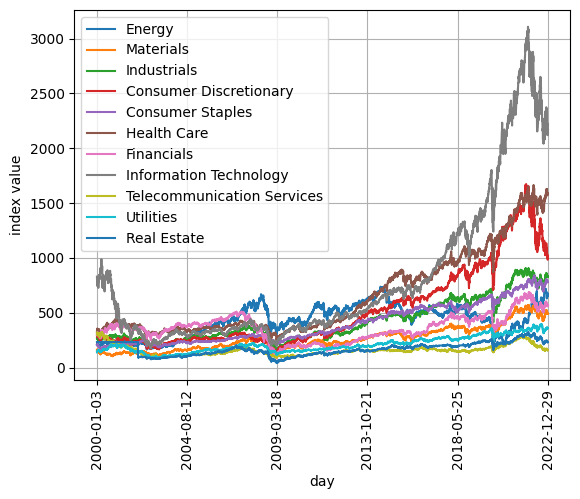

In [10]:
fig, ax = plt.subplots(1)

for i, (idx_name, idx_key) in enumerate(zip(name_list, index_list)):
    dat = data['Adj Close'][idx_key].to_numpy()
    if i == 0:
        pass
        # dat /= 11
        # ax.plot(dat, label=idx_name, color="black")
    else:
        ax.plot(dat, label=idx_name)
ax.legend()
ax.set_xlabel("day")
ax.set_ylabel("index value")
ax.grid()
n_ticks=5
tick_pos = np.arange(0, len(date_list), len(date_list)//n_ticks)
ax.set_xticks(tick_pos, [date_list[i] for i in tick_pos], rotation="vertical")
plt.show()


In [11]:
data_vix_same_dates = data_vix['Adj Close'][date_list].to_numpy(dtype=np.float32)

data_vix_normalized_lookback = np.zeros_like(data_vix_same_dates)
for i in range(len(data_vix_normalized_lookback)):
    mean = np.mean(data_vix_same_dates[:i+1])
    std = np.std(data_vix_same_dates[:i+1])
    data_vix_normalized_lookback[i] = (data_vix_same_dates[i] - mean) / std
np.save("vix.npy", data_vix_same_dates)
np.save("vix_normed_lookback.npy", data_vix_normalized_lookback)

/tmp/ipykernel_27677/4277907151.py:7: RuntimeWarning: invalid value encountered in scalar divide
  data_vix_normalized_lookback[i] = (data_vix_same_dates[i] - mean) / std


Text(0.5, 1.0, 'VIX normed')

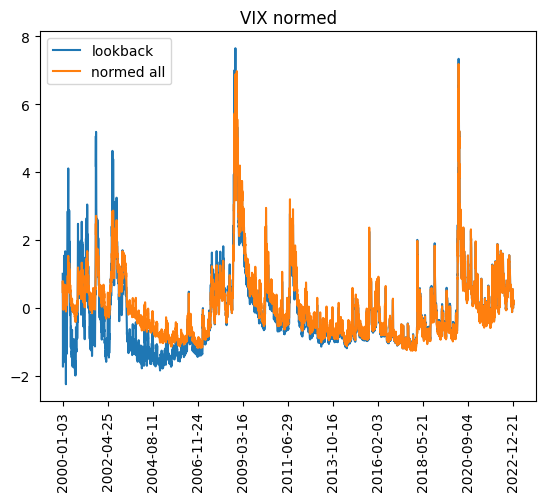

In [12]:
fig, ax = plt.subplots(1)
plt.plot(data_vix_normalized_lookback, label="lookback")
plt.plot((data_vix_same_dates - np.mean(data_vix_same_dates))/np.std(data_vix_same_dates), label="normed all")
n_ticks=10
tick_pos = np.arange(0, len(date_list), len(date_list)//n_ticks)
ax.set_xticks(tick_pos, [date_list[i] for i in tick_pos], rotation="vertical")
plt.legend()
plt.title("VIX normed")

In [13]:
data_np = data['Adj Close'].to_numpy()
print(data_np.shape)
data_log_returns = np.zeros(data_np.shape, dtype=np.float32)
data_simple_returns = np.zeros(data_np.shape, dtype=np.float32)

for i in range(1, data_np.shape[0]):
    data_log_returns[i] = np.log(data_np[i]/data_np[i-1])
    data_simple_returns[i] = data_np[i]/data_np[i-1] - 1

np.save("indices_log_returns.npy", data_log_returns)
np.save("indices_simple_returns.npy", data_simple_returns)
np.save("indices_share_prices.npy", data_np)

(5787, 12)


In [14]:
vol_60 = np.zeros(data_simple_returns.shape[0], dtype=np.float32)
for i in range(lookback_window_large-1, data_simple_returns.shape[0]):
    vol_60[i] = np.std(data_simple_returns[i+1-lookback_window_large : i+1])

vol_20 = np.zeros(data_simple_returns.shape[0], dtype=np.float32)
for i in range(lookback_window_small-1, data_simple_returns.shape[0]):
    vol_20[i] = np.std(data_simple_returns[i+1-lookback_window_small : i+1])

vol_20_60_quotient = vol_20/vol_60

np.save("vol_20_60_quotient.npy", vol_20_60_quotient)
np.save("vol_20.npy", vol_20)
np.save("vol_60.npy", vol_60)

/tmp/ipykernel_27677/2742688576.py:9: RuntimeWarning: divide by zero encountered in divide
  vol_20_60_quotient = vol_20/vol_60
/tmp/ipykernel_27677/2742688576.py:9: RuntimeWarning: invalid value encountered in divide
  vol_20_60_quotient = vol_20/vol_60


In [15]:
data_vol20_normalized_lookback = np.zeros_like(vol_20)

data_vol2060_normalized_lookback = np.zeros_like(vol_20_60_quotient)
start_quotient = lookback_window_large
for i in range(len(vol_20)):
    mean = np.mean(vol_20[:i+1])
    std = np.std(vol_20[:i+1])
    data_vol20_normalized_lookback[i] = (vol_20[i] - mean) / std

    mean = np.mean(vol_20_60_quotient[start_quotient:i+1])
    std = np.std(vol_20_60_quotient[start_quotient:i+1])
    data_vol2060_normalized_lookback[i] = (vol_20_60_quotient[i] - mean) / std

np.save("vol_20_60_quotient_normed_lookback.npy", data_vol2060_normalized_lookback)
np.save("vol_20_normed_lookback.npy", data_vol20_normalized_lookback)

/tmp/ipykernel_27677/1054692347.py:8: RuntimeWarning: invalid value encountered in scalar divide
  data_vol20_normalized_lookback[i] = (vol_20[i] - mean) / std
/u/mnaegel/conda-envs/sb3_1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/mnaegel/conda-envs/sb3_1/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/u/mnaegel/conda-envs/sb3_1/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/u/mnaegel/conda-envs/sb3_1/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/u/mnaegel/conda-envs/sb3_1/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: in

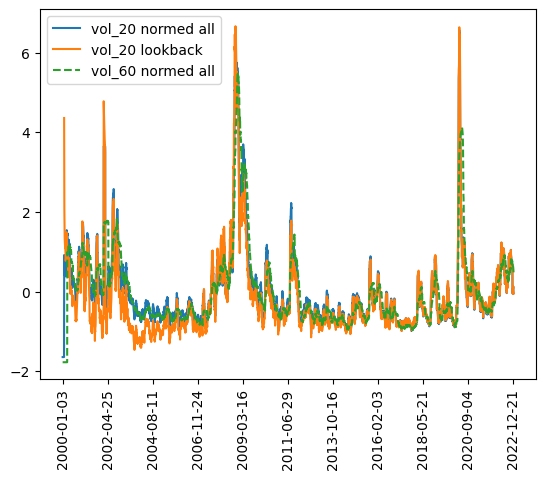

In [16]:
fig, ax = plt.subplots(1)
plt.plot((vol_20 - np.mean(vol_20)) / np.std(vol_20), label="vol_20 normed all")
plt.plot(data_vol20_normalized_lookback, label="vol_20 lookback")
plt.plot((vol_60 - np.mean(vol_60)) / np.std(vol_60), label="vol_60 normed all", linestyle="--")
n_ticks=10
tick_pos = np.arange(0, len(date_list), len(date_list)//n_ticks)
ax.set_xticks(tick_pos, [date_list[i] for i in tick_pos], rotation="vertical")
plt.legend()

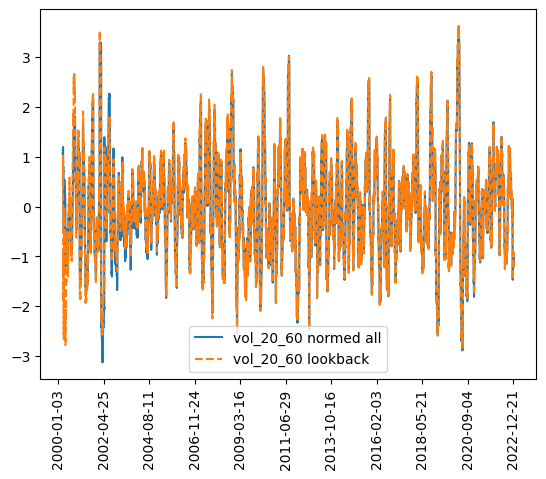

In [17]:
fig, ax = plt.subplots(1)
plt.plot((vol_20_60_quotient - np.mean(vol_20_60_quotient[start_quotient:])) / np.std(vol_20_60_quotient[start_quotient:]), label="vol_20_60 normed all")
plt.plot(data_vol2060_normalized_lookback, label="vol_20_60 lookback", linestyle="--")
n_ticks=10
tick_pos = np.arange(0, len(date_list), len(date_list)//n_ticks)
ax.set_xticks(tick_pos, [date_list[i] for i in tick_pos], rotation="vertical")
plt.legend()

# Random stuff:

/tmp/ipykernel_27677/2070671909.py:4: RuntimeWarning: divide by zero encountered in divide
  geom_mean = (np.exp( (1 / np.arange(0, len(data_log_returns[:, idx]))) *  np.cumsum(data_log_returns[:, idx])))
/tmp/ipykernel_27677/2070671909.py:4: RuntimeWarning: invalid value encountered in multiply
  geom_mean = (np.exp( (1 / np.arange(0, len(data_log_returns[:, idx]))) *  np.cumsum(data_log_returns[:, idx])))


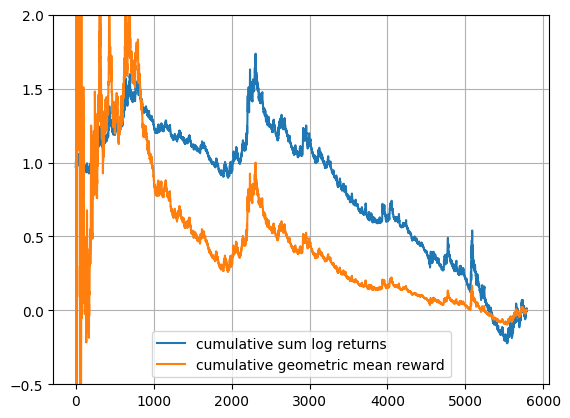

In [18]:
idx = 0
scale = 2000
plt.plot(np.cumsum(data_log_returns[:, idx][::-1])[::-1], label="cumulative sum log returns")
geom_mean = (np.exp( (1 / np.arange(0, len(data_log_returns[:, idx]))) *  np.cumsum(data_log_returns[:, idx])))
plt.plot((geom_mean[-1] - geom_mean) * scale, label="cumulative geometric mean reward")
plt.ylim(-0.5, 2)
plt.grid()
plt.legend()